In [142]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from decimal import Decimal, getcontext

getcontext().prec = 28 

In [ ]:
# Define states
states = ["Mean Reverting", "Trending", "Random Walk"]

# Initialize transition probability matrix (example values)
transition_matrix = np.array([
    [0.7, 0.2, 0.1], 
    [0.2, 0.7, 0.1],  
    [0.2, 0.3, 0.5]  
])

def simulate_markov_chain(trans_matrix, states, num_steps):
    """
    Simulate a Markov chain given a transition matrix, states, and number of steps.
    """
    current_state = np.random.choice(states)
    chain = [current_state]

    for _ in range(num_steps - 1):
        current_state_idx = states.index(current_state)
        next_state_idx = np.random.choice(range(len(states)), p=trans_matrix[current_state_idx])
        current_state = states[next_state_idx]
        chain.append(current_state)

    return chain

# Simulate the Markov chain
num_steps = 10
markov_chain = simulate_markov_chain(transition_matrix, states, num_steps)
print("Simulated Markov Chain:", markov_chain)

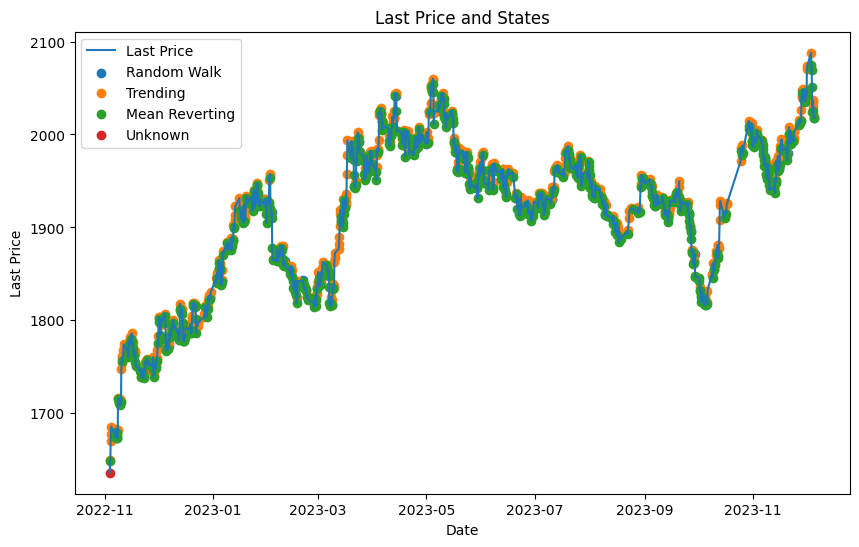

In [63]:
# Sample data
data = pd.read_csv('Gold Four-Hour.csv', parse_dates=['Date'])

# Convert to DataFrame
df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Determine states
threshold = 0.5  # Threshold for considering price as "same"
states = []
previous_price = None
for price in df['Last Price']:
    if previous_price is None:
        state = 'Unknown'
    elif price > previous_price + threshold:
        state = 'Trending'
    elif price < previous_price - threshold:
        state = 'Mean Reverting'
    else:
        state = 'Random Walk'
    states.append(state)
    previous_price = price

df['State'] = states

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Last Price'], label='Last Price')
for state in set(states):
    mask = df['State'] == state
    plt.scatter(df['Date'][mask], df['Last Price'][mask], label=state)
plt.xlabel('Date')
plt.ylabel('Last Price')
plt.title('Last Price and States')
plt.legend()
plt.show()

In [64]:
def calculate_features(data):
    """
    Calculate the Momentum Indicator, Moving Averages, and MACD for the dataset.
    """
    # Momentum Indicator (e.g., simple rate of price change)
    data['Momentum'] = data['Last Price'].pct_change(periods=1)

    # Moving Averages
    short_window = 10
    long_window = 50
    data['Short_MA'] = data['Last Price'].rolling(window=short_window, min_periods=1).mean()
    data['Long_MA'] = data['Last Price'].rolling(window=long_window, min_periods=1).mean()

    # MACD
    data['MACD'] = data['Short_MA'] - data['Long_MA']

    return data

In [65]:
df = calculate_features(df)
print(df)

                    Date  Last Price           State  Momentum  Short_MA  \
1459 2022-11-03 18:00:00      1636.0         Unknown       NaN   1636.00   
1458 2022-11-03 22:00:00      1649.4        Trending  0.008191   1642.70   
1457 2022-11-04 02:00:00      1648.4  Mean Reverting -0.000606   1644.60   
1456 2022-11-04 06:00:00      1670.6        Trending  0.013468   1651.10   
1455 2022-11-04 10:00:00      1677.9        Trending  0.004370   1656.46   
...                  ...         ...             ...       ...       ...   
4    2023-12-04 22:00:00      2036.6        Trending  0.000737   2055.21   
3    2023-12-05 02:00:00      2025.0  Mean Reverting -0.005696   2050.61   
2    2023-12-05 06:00:00      2018.1  Mean Reverting -0.003407   2045.10   
1    2023-12-05 10:00:00      2017.8     Random Walk -0.000149   2038.08   
0    2023-12-05 14:00:00      2019.6        Trending  0.000892   2032.56   

       Long_MA    MACD  
1459  1636.000   0.000  
1458  1642.700   0.000  
1457  1644.6

In [66]:
def calculate_observation_probability(feature_value, state_mean, state_variance):
    """
    Calculate the probability of observing a feature value given a state's Gaussian distribution.
    """
    # Assuming a Gaussian distribution for observation probability
    prob = (np.exp(-0.5 * ((feature_value - state_mean) ** 2) / state_variance) / 
            np.sqrt(2 * np.pi * state_variance))
    return prob

In [67]:
def decimal_gaussian_prob(x, mean, variance):
    """
    Calculate the Gaussian probability of x for a given mean and variance using Decimal.
    """
    x = Decimal(x)
    mean = Decimal(mean)
    variance = Decimal(variance)
    
    coeff = Decimal(1) / (Decimal(2) * Decimal("3.14159265358979323846264338327950288419716939937510").sqrt() * variance.sqrt())
    exponent = Decimal("-0.5") * ((x - mean) ** Decimal(2)) / variance
    return coeff * exponent.exp()

def viterbi_algorithm(observations, states, start_prob, trans_prob, state_means, state_variances):
    N = len(observations)  
    M = len(states)        

    # Initialize Viterbi and backpointer tables
    viterbi_table = [[Decimal(0) for _ in range(M)] for _ in range(N)]
    backpointer = [[0 for _ in range(M)] for _ in range(N)]

    # Initialize first row of Viterbi table
    for s in range(M):
        obs_prob = Decimal(1)
        for f in range(len(observations[0])):
            obs_prob *= decimal_gaussian_prob(observations[0][f], state_means[s][f], state_variances[s][f])
        viterbi_table[0][s] = Decimal(start_prob[s]) * obs_prob

    # Fill in the Viterbi table
    for t in range(1, N):
        for s in range(M):
            prob_list = []
            for s_prev in range(M):
                trans_prob_ss_prev = Decimal(trans_prob[s_prev][s])
                obs_prob = Decimal(1)
                for f in range(len(observations[t])):
                    obs_prob *= decimal_gaussian_prob(observations[t][f], state_means[s][f], state_variances[s][f])
                prob = viterbi_table[t - 1][s_prev] * trans_prob_ss_prev * obs_prob
                prob_list.append(prob)
            max_prob = max(prob_list)
            viterbi_table[t][s] = max_prob
            backpointer[t][s] = prob_list.index(max_prob)

    # Traceback to find the best path
    best_path = []
    last_state = max(range(M), key=lambda s: viterbi_table[N - 1][s])
    best_path.append(last_state)

    for t in range(N - 1, 0, -1):
        last_state = backpointer[t][last_state]
        best_path.insert(0, last_state)

    # Convert state indices to state names
    best_path_states = [states[i] for i in best_path]

    return best_path_states


In [68]:
def decimal_gaussian_prob(x, mean, variance):
    """
    Calculate the Gaussian probability of x for a given mean and variance using Decimal.
    """
    x = Decimal(x)
    mean = Decimal(mean)
    variance = Decimal(variance)
    
    coeff = Decimal(1) / (Decimal(2) * Decimal("3.14159265358979323846264338327950288419716939937510").sqrt() * variance.sqrt())
    exponent = Decimal("-0.5") * ((x - mean) ** Decimal(2)) / variance
    return coeff * exponent.exp()

def forward_procedure(observations, states, start_p, trans_p, state_means, state_variances):
    """
    Forward procedure using Decimal for higher precision.
    """
    N = len(observations)
    M = len(states)
    
    # Initialize forward probabilities matrix
    forward = [[Decimal(0) for _ in range(M)] for _ in range(N)]

    # Initialize first row with starting probabilities
    for s in range(M):
        obs_prob = Decimal(1)
        for f in range(len(observations[0])):
            obs_prob *= decimal_gaussian_prob(observations[0][f], state_means[s][f], state_variances[s][f])
        forward[0][s] = Decimal(start_p[s]) * obs_prob

    # Iterate over each observation after the first
    for t in range(1, N):
        for s in range(M):
            sum_prev = Decimal(0)
            for s_prev in range(M):
                sum_prev += forward[t - 1][s_prev] * Decimal(trans_p[s_prev][s])
            obs_prob = Decimal(1)
            for f in range(len(observations[t])):
                obs_prob *= decimal_gaussian_prob(observations[t][f], state_means[s][f], state_variances[s][f])
            forward[t][s] = sum_prev * obs_prob

    return forward

In [69]:
def backward_procedure(observations, states, trans_p, state_means, state_variances):
    """
    Backward procedure using Decimal for higher precision.
    """
    N = len(observations)
    M = len(states)

    # Initialize backward probabilities matrix
    backward = [[Decimal(0) for _ in range(M)] for _ in range(N)]

    # Initialize last row with 1
    for s in range(M):
        backward[N - 1][s] = Decimal(1)

    # Iteratively update backward probabilities
    for t in range(N - 2, -1, -1):
        for s in range(M):
            sum_next = Decimal(0)
            for s_next in range(M):
                obs_prob = Decimal(1)
                for f in range(len(observations[t + 1])):
                    obs_prob *= decimal_gaussian_prob(observations[t + 1][f], state_means[s_next][f], state_variances[s_next][f])
                sum_next += Decimal(trans_p[s][s_next]) * obs_prob * backward[t + 1][s_next]
            backward[t][s] = sum_next

    return backward

In [70]:
def emit_func(observation, state_index, state_means, state_variances):
    """
    Calculate the emission probability for a given observation and state using Decimal.
    """
    mean = state_means[state_index]
    variance = state_variances[state_index]
    prob = Decimal(1)
    two_pi = Decimal(2) * Decimal("3.14159265358979323846264338327950288419716939937510")

    for feature in range(len(observation)):
        x = Decimal(observation[feature])
        m = Decimal(mean[feature])
        v = Decimal(variance[feature])
        
        coeff = Decimal(1) / (two_pi * v).sqrt()
        exponent = Decimal("-0.5") * ((x - m) ** Decimal(2)) / v
        prob *= coeff * exponent.exp()

    return prob


In [71]:
def baum_welch(obs, states, start_prob, trans_prob, state_means, state_variances, n_iter=100):
    """
    Baum-Welch algorithm for estimating HMM parameters including Gaussian emission probabilities.
    """
    for _ in range(n_iter):
        # Convert observations, probabilities, means, and variances to Decimal
        obs = [[Decimal(o) for o in observation] for observation in obs]
        start_prob = [Decimal(p) for p in start_prob]
        trans_prob = [[Decimal(p) for p in row] for row in trans_prob]
        state_means = [[Decimal(m) for m in means] for means in state_means]
        state_variances = [[Decimal(v) for v in variances] for variances in state_variances]

        # Forward and Backward probabilities
        fwd = forward_procedure(obs, states, start_prob, trans_prob, state_means, state_variances)
        bwd = backward_procedure(obs, states, trans_prob, state_means, state_variances)

        # E-step: Expectation
        xi = np.zeros((len(obs) - 1, len(states), len(states)), dtype=object)
        for t in range(len(obs) - 1):
            denom = sum(fwd[t][j] * bwd[t][j] for j in range(len(states))) or Decimal("1e-50")
            for i in range(len(states)):
                for j in range(len(states)):
                    xi[t][i][j] = (fwd[t][i] * trans_prob[i][j] * emit_func(obs[t+1], j, state_means, state_variances) * bwd[t+1][j]) / denom
        # M-step: Maximization
        for i in range(len(states)):
            start_prob[i] = fwd[0][i] * bwd[0][i]

            for j in range(len(states)):
                numerator = sum(xi[t][i][j] for t in range(len(obs) - 1))
                denominator = sum(sum(xi[t][i][k] for k in range(len(states))) for t in range(len(obs) - 1)) or Decimal("1e-50")
                trans_prob[i][j] = numerator / denominator

            for feature in range(len(obs[0])):  # For each feature
                state_obs = [o for t, o in enumerate(obs) if np.argmax([fwd[t][s].to_eng_string() for s in range(len(states))]) == i]  # Observations likely to be in state i
                if state_obs:  # Ensure there are observations for the state
                    state_means[i][feature] = sum(Decimal(o[feature]) for o in state_obs) / Decimal(len(state_obs))
                    state_variances[i][feature] = sum((Decimal(o[feature]) - state_means[i][feature]) ** 2 for o in state_obs) / Decimal(len(state_obs))

    return start_prob, trans_prob, state_means, state_variances

In [72]:
import numpy as np

def multivariate_gaussian_prob(x, mean, variance):
    """
    Calculate the multivariate Gaussian probability of x for a given mean and variance.
    x, mean, variance are numpy arrays.
    """
    k = len(x)
    det_variance = np.linalg.det(variance)
    inv_variance = np.linalg.inv(variance)
    norm_factor = np.sqrt((2 * np.pi) ** k * det_variance)

    return np.exp(-0.5 * np.dot(np.dot((x - mean).T, inv_variance), (x - mean))) / norm_factor




states = ["Mean Reverting", "Trending", "Random Walk"]
start_prob = [1/3, 1/3, 1/3]  # Example initial start probabilities
trans_prob = np.array([
    [0.6, 0.2, 0.2],  # Transition probabilities from 'Mean Reverting'
    [0.3, 0.4, 0.3],  # Transition probabilities from 'Trending'
    [0.2, 0.3, 0.5]   # Transition probabilities from 'Random Walk'
])

# Step 2: Prepare Observations
observations = df[['Momentum', 'Short_MA', 'Long_MA', 'MACD']].values
print("Observations", observations)

num_features = 4  
num_states = 3    

import pandas as pd
from sklearn.model_selection import train_test_split

train_df, test_df = df,df

# Prepare observations for the training set
train_observations = train_df[['Momentum', 'Short_MA', 'Long_MA', 'MACD']].values
train_observations = np.nan_to_num(train_observations)  # Replace NaNs

# Similarly, prepare observations for the test set
test_observations = test_df[['Momentum', 'Short_MA', 'Long_MA', 'MACD']].values
test_observations = np.nan_to_num(test_observations) 

from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

imputer = SimpleImputer(strategy='mean')
train_observations_imputed = imputer.fit_transform(train_observations)

# Apply K-means clustering to initialize state means and variances for training data
kmeans = KMeans(n_clusters=num_states, random_state=0).fit(train_observations_imputed)
train_state_means = kmeans.cluster_centers_
train_state_variances = np.array([train_observations_imputed[kmeans.labels_ == i].var(axis=0) for i in range(num_states)])
#print(state_means)
#print(state_variances)


# Step 3: Run Baum-Welch Algorithm for Training
updated_start_prob, updated_trans_prob, updated_state_means, updated_state_variances = baum_welch(train_observations, states, start_prob, trans_prob, train_state_means, train_state_variances)

print("Updated Start Prob", updated_start_prob)
print("Updated Trans prob", updated_trans_prob)
print("Updated State means", updated_state_means)
print("Updated State Variances", updated_state_variances)

# Extract the updated parameters

# Step 4: Test the Model
# Use either forward_algorithm or viterbi_algorithm for testing
# Example: Using Viterbi Algorithm for testing
predicted_test_states = viterbi_algorithm(test_observations, states, updated_start_prob, updated_trans_prob, updated_state_means, updated_state_variances)
print(predicted_test_states)

Observations [[            nan  1.63600000e+03  1.63600000e+03  0.00000000e+00]
 [ 8.19070905e-03  1.64270000e+03  1.64270000e+03  0.00000000e+00]
 [-6.06281072e-04  1.64460000e+03  1.64460000e+03  0.00000000e+00]
 ...
 [-3.40740741e-03  2.04510000e+03  2.02941800e+03  1.56820000e+01]
 [-1.48654675e-04  2.03808000e+03  2.02983400e+03  8.24600000e+00]
 [ 8.92060660e-04  2.03256000e+03  2.03033800e+03  2.22200000e+00]]


/Users/mehdidaoudi/.conda/envs/markovModel/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Updated Start Prob [Decimal('4.235256283007195586595000775E-840883'), Decimal('3.190571184446662487672221964E-840813'), Decimal('4.803766147531310478795779359E-840810')]
Updated Trans prob [[Decimal('0.9907860353383762397259905479'), Decimal('0.007471724738045532769708386151'), Decimal('0.001742239923578227504301074282')], [Decimal('0.0005828201938232993815508446300'), Decimal('0.9975856951457181012274198855'), Decimal('0.001831484660458599391029267823')], [Decimal('0.01714727299646563279659882513'), Decimal('0.0007916921230422930201666877087'), Decimal('0.9820610348804920741832344879')]]
Updated State means [[Decimal('0.0001898243898220741328082181637'), Decimal('1919.964751619870415906641595'), Decimal('1912.888372926337294575401742'), Decimal('7.076378693533121331239855376')], [Decimal('-0.00006366683712064414316445529571'), Decimal('1912.410158512122791515992256'), Decimal('1909.543615532227904839687870'), Decimal('2.866542979894886676304386908')], [Decimal('0.000371934688194853139

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split

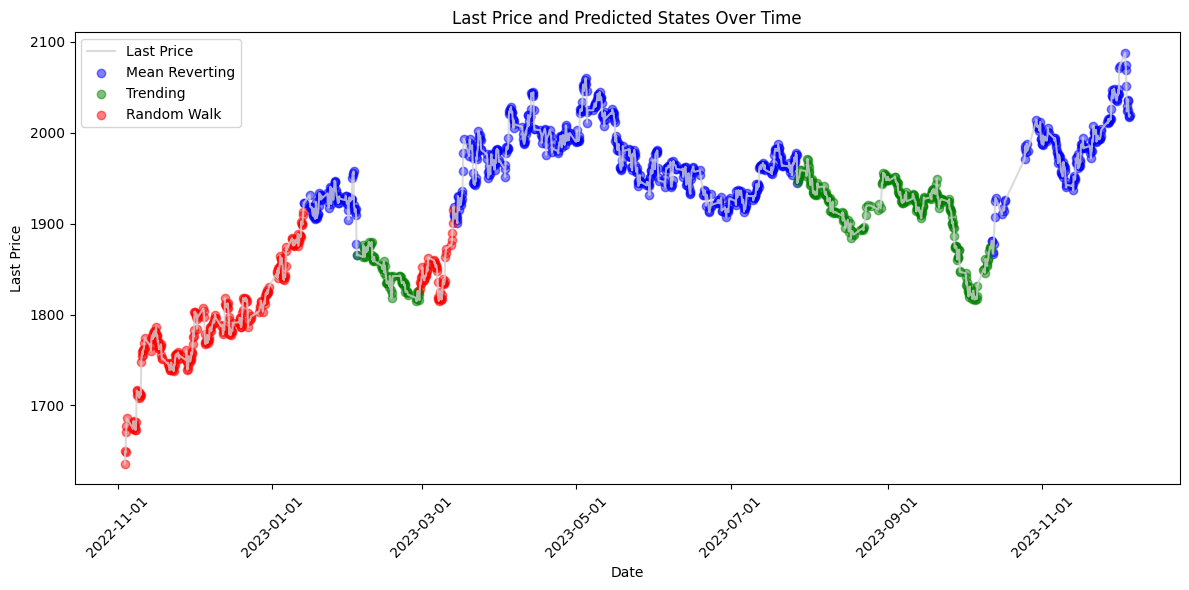

In [73]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assuming 'test_df' has been appropriately split and 'predicted_states' has been calculated
test_df['Predicted_State'] = predicted_test_states  # Make sure this line is correctly assigning the states
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.sort_values('Date', inplace=True)

# Plot settings
plt.figure(figsize=(12, 6))
colors = {'Mean Reverting': 'blue', 'Trending': 'green', 'Random Walk': 'red'}

# Plot the price data
plt.plot(test_df['Date'], test_df['Last Price'], label='Last Price', color='lightgray', alpha=0.8)

# Plot each state with its respective color
for state, color in colors.items():
    state_df = test_df[test_df['Predicted_State'] == state]
    plt.scatter(state_df['Date'], state_df['Last Price'], color=color, label=state, alpha=0.5)

# Formatting the plot
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xlabel('Date')
plt.ylabel('Last Price')
plt.title('Last Price and Predicted States Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
